# Example KNN
In this notebook, we will go through two examples on how to use the class KNN. We will first apply it on a toy example using our own generated data. Then, we will use the class to classify cancer by predicting if it is malignant or benign.

In [1]:
# Import useful libraries
from knn import KNN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

SEED = 42

## Example I - Toy example with randomly generated data
In this example, we generate data from six different multivariate guassian distributions, all with the same covariance structure. Then, we use KNN to classify three arbitrary points.

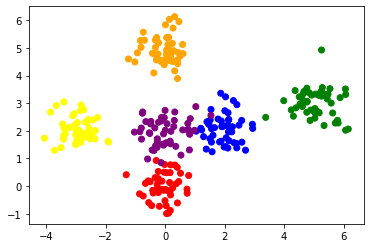

In [2]:
# Generate data from 6 multivariate normal distributions
n = 50
mu = [[0, 0], [2,2], [5,3], [-3, 2], [0,2], [0, 5]]

# Set seed for reproducibility
np.random.seed(SEED)

# Concatenate all data
data = np.concatenate((np.random.randn(n,2)/2 + mu[0], np.random.randn(n,2)/2 + mu[1]))
for i in range(2,6):
    data = np.concatenate((data, np.random.randn(n,2)/2 + mu[i]))

labels = np.repeat([i for i in range(6)], n)

colors = np.array(['red', 'blue', 'green', 'yellow', 'purple', 'orange'])
plt.scatter(data[:,0], data[:,1], c=colors[labels])

In [3]:
# Append labels to satisfy the format-requirement of the class KNN
data = np.append(data, np.reshape(labels, (labels.shape[0],1)), axis=1)

# Create a model
model = KNN(data, k=5)

# Generate new points
new_points = np.random.randn(3,2)*3

# Predict labels on new points
predictions = model.predict(new_points)
print(predictions)

[0. 1. 5.]


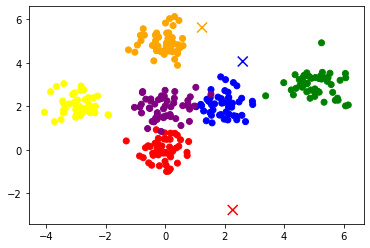

In [4]:
# Plot the predictions together with the data
predicted_col = [colors[int(prediction)] for prediction in predictions]
plt.scatter(data[:,0], data[:,1], c=colors[labels])
plt.scatter(new_points[:,0], new_points[:,1], c=predicted_col, marker='x', s=100)

We see that the classifications (illustrated as crosses) are reasonable and what we would expect from the KNN algorithm.

## Example II
In this example we use the class KNN to predict if cancer is malignant or benign. We perform hyper-parameter optimization using Leave One Out Cross-Validation (LOOCV). Then, we train a final model and test it on test data.

In [5]:
# Load data
all_data = load_breast_cancer()

In [6]:
print(f"We have {len(all_data['feature_names'])} recorded features.")
print(all_data['feature_names'])

We have 30 recorded features.
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [7]:
print(f"We have {np.sum(np.isnan(data))} missing values.")

We have 0 missing values.


We see that we have 30 recorded features with no missing values. We continue by standardizing the values. Then we proceed with finding the optimal value of k by using LOOCV. We try every odd k from 3 to 19.

In [8]:
# Extract features (X) and labels (y)
X = all_data['data']
y = all_data['target']
# Standardize
X_std = (X - np.mean(X,axis=0)) / np.std(X, axis=0)

In [9]:
# Split all data into training data (85%) and test data (15%)
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=int(X_std.shape[0]*0.15), random_state=SEED)

In [10]:
# Try every odd k from 3 to 19
cv_error_all_k = []
for k in range(3, 20, 2):
    # We calculate the average missclassification rate, we let that represent the cross-validation error
    cv_error = np.ones(X_train.shape[0])
    for i in range(X_train.shape[0]):
        train_data = np.append(np.delete(X_train,i,axis=0), np.reshape(np.delete(y_train,i), (X_train.shape[0]-1,1)), axis=1)            
        model = KNN(train_data, k)
        cv_error[i] = (model.predict(np.reshape(X_train[i,:], (1, X_train[i,:].shape[0]))) != y_train[i])
    cv_error_all_k.append(np.sum(cv_error)/len(cv_error)*100)

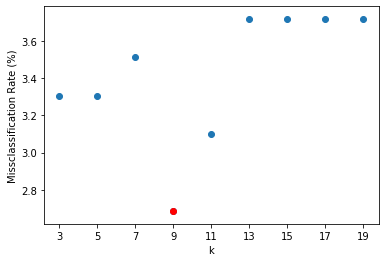

In [11]:
# Plot the missclassification rate for each k
plt.scatter(range(3, 20, 2), cv_error_all_k)
plt.xticks(range(3, 20, 2))
plt.xlabel("k")
plt.ylabel("Missclassification Rate (%)")

# Mark the lowest k as red
plt.scatter(3 + np.argmin(cv_error_all_k)*2, np.min(cv_error_all_k), c='red')

We see that we had the lowest missclassifcation rate with k=9. Now, we train a model with k=13 and test it on the test data. We evaluate the final model using a confusion matrix.

In [12]:
# Now we test our model with k=9 on the test data

# Train final model
final_model = KNN(np.append(X_train, np.reshape(y_train, (len(y_train),1)), axis=1), k=9)

# Predict on test data
predictions = final_model.predict(X_test)

# Calculate accuracy
accuracy = np.sum(predictions==y_test)/len(y_test)
print(f"The final model has an accuracy of: {accuracy*100:.2f}%")

The final model has an accuracy of: 95.29%


In [13]:
# A function for printing a confusion matrix
def print_confusion_matrix(true, predictions):
    print("                   TRUE")
    print("                  1     0")
    print("---------------------------")
    print(f"Predicted   1|   {sum(y_test[predictions==1]==1)}     {sum(y_test[predictions==1]==0)}")
    print(f"            0|   {sum(y_test[predictions==0]==1)}     {sum(y_test[predictions==0]==0)}")

In [14]:
print_confusion_matrix(y_test, predictions)

                   TRUE
                  1     0
---------------------------
Predicted   1|   52     2
            0|   2     29


We see that we had only 4 missclassified observation. We predicted 2 observations as benign, when it was malignant and two vice versa. But, the total accuracy was an impressive 95.29%!.